In [4]:
import gc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import sys
from sklearn.neighbors import NearestNeighbors
from multiprocessing import Pool
sys.path.append('../')
import loaders
import data
from extern.quarterTools import data_scaler

import warnings
from lightkurve import LightkurveWarning
warnings.filterwarnings("ignore", category=LightkurveWarning)



SEED = 12345
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
### Uncomment to mount the drive and/or bucket

#lcs stored on drive for quick access
data.mount_drive('/mnt/disks/lcs/')

#other data products stored on google bucket
!gcsfuse --implicit-dirs tess-goddard-lcs /home/jupyter/mountpoint

Disk mounted
I0710 16:39:48.159500 2023/07/10 16:39:48.159474 Start gcsfuse/0.42.4 (Go version go1.19.7) for app "" using mount point: /home/jupyter/mountpoint


# Features

In [6]:
from extern import features

In [7]:
def get_subset(s):
    """Returns the subset features used to rescore a sector.
    
    Note: only Sector 18 has been rescored and had the reference subset
    saved as of 7/7/2023. 
    """
    try:
        df = feats  # if feats is defined in an earlier block
    except:
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")

    subset_tics = np.loadtxt(f"/home/jupyter/mountpoint/dataproducts/s{s}_score_reference.txt")
    sample_subset = df.loc[subset_tics]
    return sample_subset

from sklearn import preprocessing

def data_scaler(data_to_scale, s=18):
    """Scales given features by the same factors as the given sector.
    
    This method recalculates the factors needed to scale each feature for a
    given sector. The features are scaled and shifted such that each set of
    features has a mean of zero and a standard deviation of one for
    the features calculated for all light curves in the given sector.
    
    Though possible, newly scaled data should not be expected to have a mean
    of zero or a standard a deviation of one for any feature.
    """
    try:
        df = feats.iloc[:, 0:61]
    except: 
        datafile = "/home/jupyter/mountpoint/dataproducts/db.v2.h5"
        df = pd.read_hdf(datafile, f"S{s}/features")[:, 0:61]  # including mstat but not astat

    scaler = preprocessing.StandardScaler().fit(df)
    scaled = scaler.transform(data_to_scale)
    scaled = pd.DataFrame(index=data_to_scale.index,
                                columns=df.columns,
                                data=scaled)
    return scaled

def score_scaler(score):
    """Rescales "raw" scores to match Sector 18 rescored
    
    Calculated based on reference points. Not perfect, but pretty good
    Note: can't do similar to data_scaler because "raw" scores aren't saved
    """
    factor = 0.00018255470902209855
    offset = -4.34047914797675e-12
    scaled = score*factor+offset
    return scaled

def dist_scores(ref_data, d2s=None, k=1, scaler=False):
    """
    This method calculates the distance to the k-th neighbor in the reference data
    Args:
        ref_data (Numpy array or Pandas dataframe) - The reference data to which
            distances will be calculated
        d2s (Numpy array or Pandas dataframe) - Data to be scored (if None,
            same as the reference data)
        k (integer) - neighbor to calculate the distance

    Returns:
        scores (Numpy array) - distances for data in d2s.
    """


    if isinstance(d2s, type(None)):
        # if d2s is a dataframe, the evaluation of d2s==None tries to compare
        # every value of the dataframe to None, instead we check if it's
        # NoneType
        d2s = ref_data  # will default to full data if d2s is not specified

    if isinstance(scaler, type(data_scaler)):
        ref_data = scaler(ref_data)
        d2s = scaler(d2s)
    nbrs = NearestNeighbors(
        n_neighbors=k+1, algorithm='ball_tree', n_jobs=-1).fit(ref_data)
    distances, indices = nbrs.kneighbors(d2s)

    scores = score_scaler(distances[:, k])

    return scores

KeyError: 'Flux7'

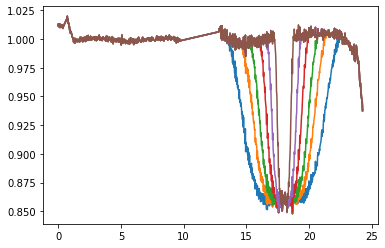

In [11]:
#check import of plots
shape = "Triangle"
fluxes = pd.read_csv("subplot_data/" + shape+ "_width_spike.csv")
for num in range(1,13):
    plt.plot(fluxes['Time'].values,fluxes["Flux%s" %(num)].values)
print(fluxes)


In [12]:
import os
# Mount data either from disk or bucket

#use first except statement for bucket
#for histogram use first try statement

try:
    # First try to load data from the disk, it's faster than bucket access
    data_dir = "/mnt/disks/lcs/tess-goddard-lcs/"  # path for disk
    ref = pd.read_csv(data_dir+"sector1lookup.csv") # test if ref file can be loaded
except:
    try: 
        data.mount_drive("/mnt/disks/lcs")
        ref = pd.read_csv(data_dir+"sector1lookup.csv") # test if ref file can be loaded
    except:
        # if the ref file can't be loaded, try using the bucket
        from pathlib import Path
        home = str(Path.home()) # getting the path to the home directory
        data_dir = home + "/mountpoint/"  # path for bucket
        try:
            # check if the lookup file for sector one exists
            ref = pd.read_csv(data_dir+"sector1lookup.csv")
        except FileNotFoundError:
            # If the ref file can't be found, the bucket might not be mounted
            # this attempts to mount it.
            os.system(
                f"gcsfuse --implicit-dirs tess-goddard-lcs {data_dir}"
            )
            ref = pd.read_csv(data_dir+"sector1lookup.csv")
            
from pathlib import Path
home = str(Path.home()) # getting the path to the home directory
data_dir = home + "/mountpoint/"  # path for bucket
# check if the lookup file for sector one exists
# If the ref file can't be found, the bucket might not be mounted
# this attempts to mount it.
os.system(
    f"gcsfuse --implicit-dirs tess-goddard-lcs {data_dir}"
)

## for a given sector/camera

ref = pd.read_csv(data_dir+"sector18lookup.csv") #sector 18 camera 2

i = 18
j = 2

subref = ref[(ref.Sector==i)&(ref.Camera==j)&(ref.Magnitude>12)&(ref.Magnitude<13)] #mag 12 find unfuzzy lightcurve, pull in flux_err # shape, size, velocity


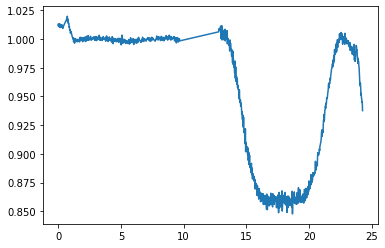

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.059253    0.957888  0.003511  0.062082     266.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.008038    0.131895  ...      -0.476643   

        mbp     mid20     mid35    mid50     mid65    mid80  percentamp  \
0  0.570978  0.161946  0.473462  0.78283  0.915751  0.95635     0.14921   

   magratio  mstat  
0  0.146768  1.092  

[1 rows x 61 columns]


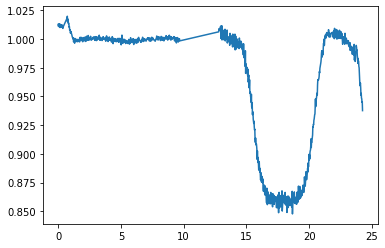

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.054971    0.967586  0.003022  0.056923     213.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.004608    0.134466  ...      -0.467309   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.671924  0.026148  0.129302  0.425595  0.844769  0.951528    0.150638   

   magratio  mstat  
0  0.136518  1.188  

[1 rows x 61 columns]


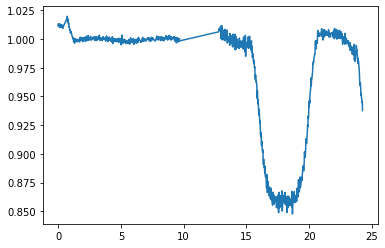

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.051084    0.973927  0.00261  0.052529     178.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.00394    0.135435  ...      -0.455731   

       mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.73081  0.017724  0.047327  0.151014  0.667629  0.943745    0.151031   

   magratio  mstat  
0   0.13362  1.272  

[1 rows x 61 columns]


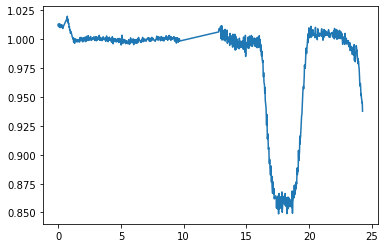

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.045089    0.981117  0.002033  0.045998     136.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.003149    0.135946  ...      -0.437167   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.798107  0.014014  0.028614  0.057018  0.270331  0.868895    0.150474   

   magratio  mstat  
0  0.130302  1.417  

[1 rows x 61 columns]


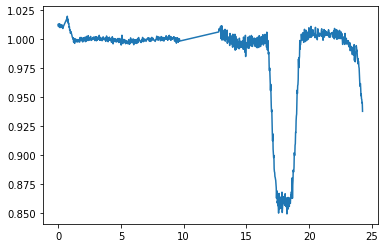

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.03902    0.986606  0.001523  0.039573     101.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.00266    0.135861  ...      -0.405734   

        mbp     mid20     mid35     mid50   mid65     mid80  percentamp  \
0  0.850683  0.012411  0.024255  0.041241  0.0805  0.465982    0.150486   

   magratio  mstat  
0  0.129444  1.483  

[1 rows x 61 columns]


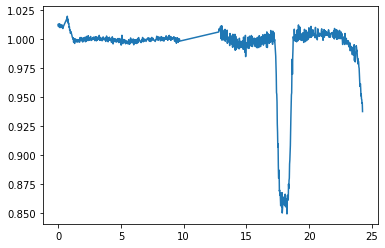

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.030452     0.99228  0.000927  0.030698      69.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0            35.0         35.0  0.002409     0.13679  ...      -0.330777   

       mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.90326  0.015619  0.030992  0.048193  0.085473  0.186735    0.150322   

   magratio  mstat  
0  0.130535  1.232  

[1 rows x 61 columns]
[17355. 23994. 29670. 39688. 62487. 76984.]


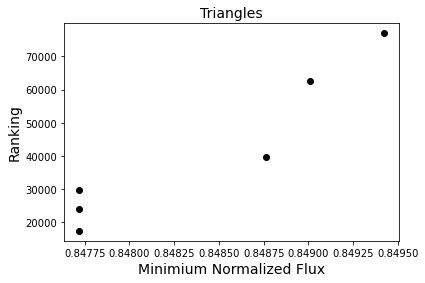

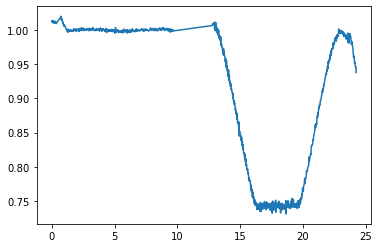

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.105704    0.926054  0.011173  0.115352     242.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.015446     0.13611  ...      -0.423998   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.564669  0.208246  0.477081  0.738844  0.956247  0.981916    0.261197   

   magratio  mstat  
0  0.109658  1.103  

[1 rows x 61 columns]


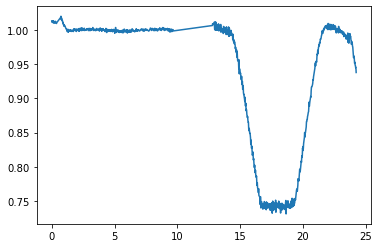

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.098382    0.939303  0.009679  0.104978     202.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.005322    0.136644  ...      -0.399257   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.660358  0.026132  0.163657  0.433632  0.811108  0.970655    0.267271   

   magratio  mstat  
0  0.080068  1.255  

[1 rows x 61 columns]


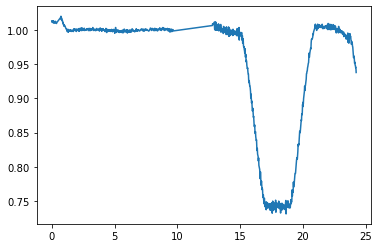

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.09151    0.951305  0.008374  0.096361     173.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.004115    0.138881  ...      -0.374681   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.724501  0.011365  0.037533  0.191809  0.612523  0.964167    0.267664   

   magratio  mstat  
0  0.078127  1.347  

[1 rows x 61 columns]


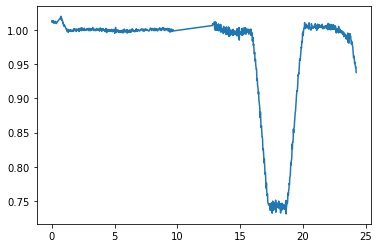

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.080688      0.9649  0.006511  0.083707     136.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.003318    0.139647  ...      -0.326499   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.799159  0.008143  0.017352  0.036311  0.226091  0.808433    0.268195   

   magratio  mstat  
0  0.075447  1.495  

[1 rows x 61 columns]


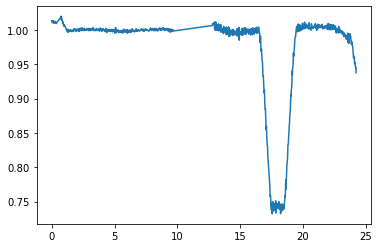

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.069676    0.975269  0.004855  0.071493     100.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.002806    0.141468  ...      -0.259718   

        mbp    mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.853838  0.00738  0.013824  0.024245  0.057201  0.461279    0.267376   

   magratio  mstat  
0  0.074734  1.543  

[1 rows x 61 columns]


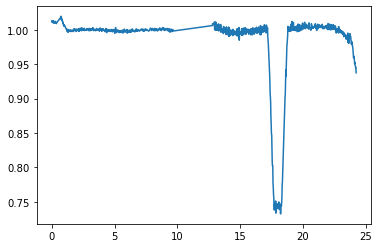

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.053887    0.985926  0.002904  0.054674      61.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0            33.0         33.0  0.00243    0.146435  ...      -0.114721   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.913775  0.009966  0.019558  0.031083  0.05507  0.138946    0.267407   

   magratio  mstat  
0  0.074412  1.276  

[1 rows x 61 columns]
[13020. 17870. 23994. 35075. 45742. 68837.]


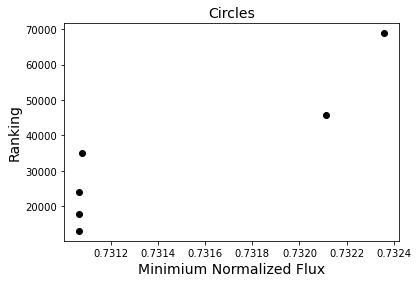

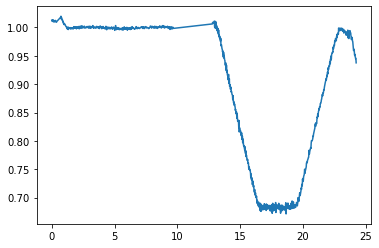

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.127221    0.910403  0.016185  0.141642     235.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.020176    0.137272  ...       -0.39504   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.561514  0.239245  0.485777  0.696222  0.930198  0.984583     0.31975   

   magratio  mstat  
0  0.098899  1.126  

[1 rows x 61 columns]


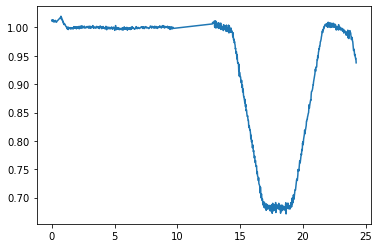

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.118615    0.925725  0.01407  0.128436     200.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.005564    0.138071  ...      -0.363423   

        mbp     mid20    mid35    mid50     mid65     mid80  percentamp  \
0  0.652997  0.023688  0.17327  0.44634  0.756635  0.970721    0.327287   

   magratio  mstat  
0  0.066075   1.29  

[1 rows x 61 columns]


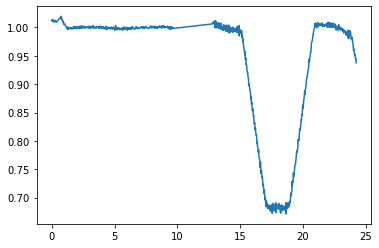

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.110395    0.940382  0.012187  0.117599     174.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.004239    0.141477  ...      -0.330836   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.720294  0.009389  0.034719  0.201978  0.59174  0.944394    0.327709   

   magratio  mstat  
0  0.064208  1.381  

[1 rows x 61 columns]


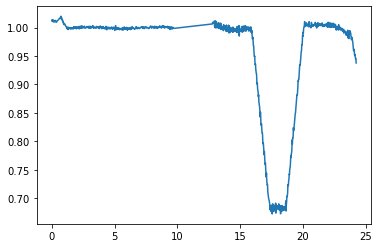

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.097381    0.957112  0.009483  0.101846     137.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.003344    0.142613  ...      -0.269362   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.798107  0.006745  0.014775  0.030681  0.25834  0.754928    0.327164   

   magratio  mstat  
0  0.062093  1.507  

[1 rows x 61 columns]


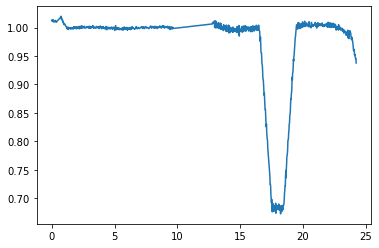

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.084108    0.969791  0.007074  0.086789     104.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.002822    0.145232  ...      -0.187733   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.853838  0.006122  0.011511  0.020193  0.055731  0.476113    0.327117   

   magratio  mstat  
0  0.061503   1.55  

[1 rows x 61 columns]


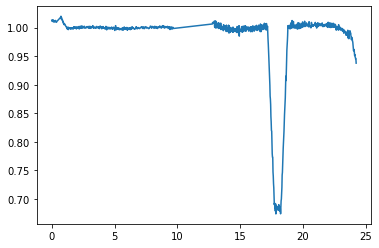

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.064942    0.982887  0.004217  0.066094      64.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0            32.0         32.0  0.00243    0.150806  ...      -0.021567   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.913775  0.008395  0.016474  0.026182  0.046387  0.119086    0.326174   

   magratio  mstat  
0  0.060993  1.292  

[1 rows x 61 columns]
[13532. 15837. 22425. 35688. 45566. 81211.]


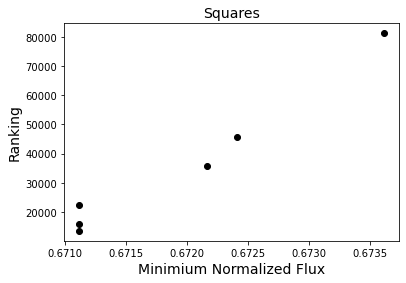

In [15]:
#depths

rank_scores = np.array([])
to_score_total = pd.DataFrame()
feats = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/db.v2.h5", "S18/features")
sector_scores = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/s18rescore.h5", "S18/scores")

for shape in ( 'Triangle','Circle', 'Square'):
    fluxes = pd.read_csv("subplot_data/" + shape+ "_depth_spike.csv")
    shape_scores = np.array([])
    shape_depths = np.array([])
    if shape == 'Triangle':
        depths = range(1,7)
    else:
        depths = range(1,13)
    for num in depths:
        plt.plot( fluxes['Time'].values,fluxes["Flux%s" %(num)].values)
        plt.show()

        test_time = fluxes["Time"].values
        test_flux = fluxes["Flux%s" %(num)].values
        test_err = np.zeros_like(test_flux, dtype='uint8')
        
        
        
        test_features = features.feats(test_time, test_flux, test_err)

        test_features = pd.DataFrame(columns=test_features.keys(), data=[test_features.values()])

        mstat = features.calc_mstat(test_flux)

        test_features['mstat'] = mstat
        test_feats =test_features
        print(test_feats)

        # Scoring 

        sample_subset = get_subset(18).iloc[:,:61]
        to_score = test_feats        
        #print(to_score)

        to_score_total = to_score_total.append(to_score)
        
        
        scores = dist_scores(sample_subset, to_score, k=1, scaler=data_scaler)
        scores_df = pd.DataFrame(data=scores.T, columns=["scores"])


        shape_score = (sector_scores[sector_scores.scores>scores[0]]['rank'].max()+1)
 
        
        shape_scores = np.append(shape_scores, shape_score)

        depth = min(fluxes["Flux%s" %(num)].values)
        shape_depths = np.append(shape_depths, depth)
        #print(shape_depths)

        

    #shape_depths = 1-shape_depths
    print(shape_scores)
    plt.title(str(shape) + 's', fontsize=14)
    plt.xlabel("Minimium Normalized Flux", fontsize = 14)
    plt.ylabel("Ranking", fontsize = 14)
    plt.scatter(shape_depths, shape_scores, color = 'black')
    
    plt.show()
    
    #depths_rankings = pd.DataFrame({'Depths':shape_depths, 'Ranking':shape_scores})
    #depths_rankings.to_csv(shape + '_depths_rankings.csv', index=True)


    
#sample_subset.to_csv('sample_subset.csv', index=True)


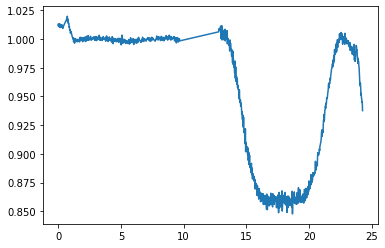

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.059253    0.957888  0.003511  0.062082     266.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.008038    0.131895  ...      -0.476643   

        mbp     mid20     mid35    mid50     mid65    mid80  percentamp  \
0  0.570978  0.161946  0.473462  0.78283  0.915751  0.95635     0.14921   

   magratio  mstat  
0  0.146768  1.092  

[1 rows x 61 columns]


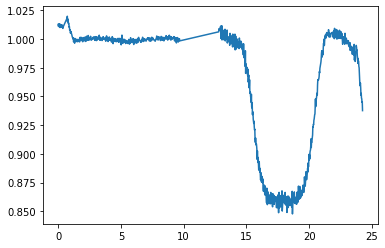

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.054971    0.967586  0.003022  0.056923     213.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.004608    0.134466  ...      -0.467309   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.671924  0.026148  0.129302  0.425595  0.844769  0.951528    0.150638   

   magratio  mstat  
0  0.136518  1.188  

[1 rows x 61 columns]


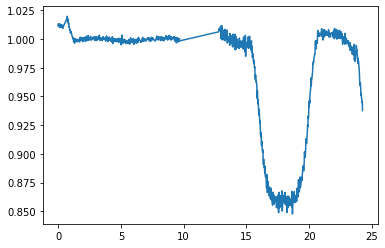

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.051084    0.973927  0.00261  0.052529     178.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.00394    0.135435  ...      -0.455731   

       mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.73081  0.017724  0.047327  0.151014  0.667629  0.943745    0.151031   

   magratio  mstat  
0   0.13362  1.272  

[1 rows x 61 columns]


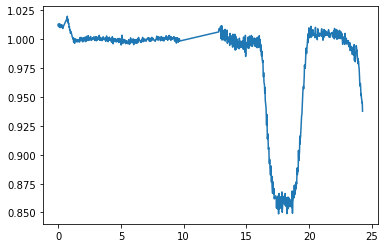

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.045089    0.981117  0.002033  0.045998     136.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.003149    0.135946  ...      -0.437167   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.798107  0.014014  0.028614  0.057018  0.270331  0.868895    0.150474   

   magratio  mstat  
0  0.130302  1.417  

[1 rows x 61 columns]


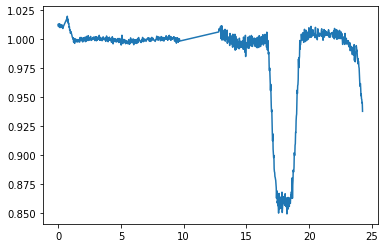

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.03902    0.986606  0.001523  0.039573     101.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.00266    0.135861  ...      -0.405734   

        mbp     mid20     mid35     mid50   mid65     mid80  percentamp  \
0  0.850683  0.012411  0.024255  0.041241  0.0805  0.465982    0.150486   

   magratio  mstat  
0  0.129444  1.483  

[1 rows x 61 columns]


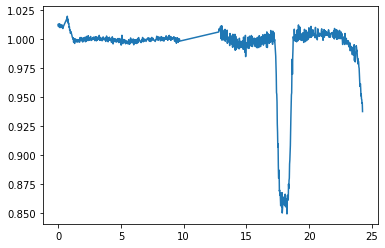

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.030452     0.99228  0.000927  0.030698      69.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0            35.0         35.0  0.002409     0.13679  ...      -0.330777   

       mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.90326  0.015619  0.030992  0.048193  0.085473  0.186735    0.150322   

   magratio  mstat  
0  0.130535  1.232  

[1 rows x 61 columns]
[17355. 23994. 29670. 39688. 62487. 76984.]


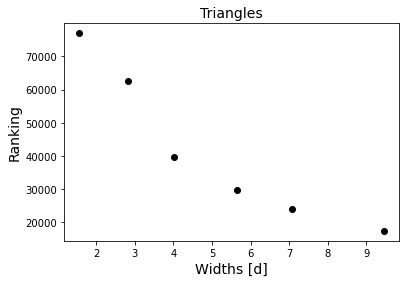

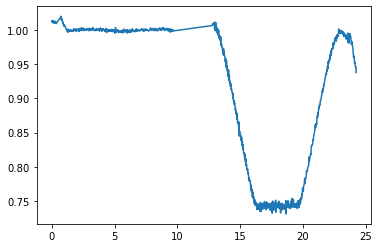

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.105704    0.926054  0.011173  0.115352     242.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.015446     0.13611  ...      -0.423998   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.564669  0.208246  0.477081  0.738844  0.956247  0.981916    0.261197   

   magratio  mstat  
0  0.109658  1.103  

[1 rows x 61 columns]


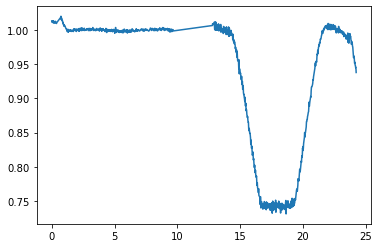

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.098382    0.939303  0.009679  0.104978     202.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.005322    0.136644  ...      -0.399257   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.660358  0.026132  0.163657  0.433632  0.811108  0.970655    0.267271   

   magratio  mstat  
0  0.080068  1.255  

[1 rows x 61 columns]


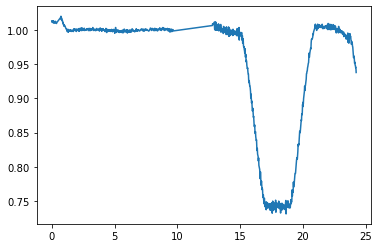

      stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.09151    0.951305  0.008374  0.096361     173.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.004115    0.138881  ...      -0.374681   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.724501  0.011365  0.037533  0.191809  0.612523  0.964167    0.267664   

   magratio  mstat  
0  0.078127  1.347  

[1 rows x 61 columns]


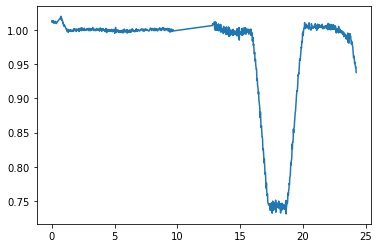

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.080688      0.9649  0.006511  0.083707     136.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.003318    0.139647  ...      -0.326499   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.799159  0.008143  0.017352  0.036311  0.226091  0.808433    0.268195   

   magratio  mstat  
0  0.075447  1.495  

[1 rows x 61 columns]


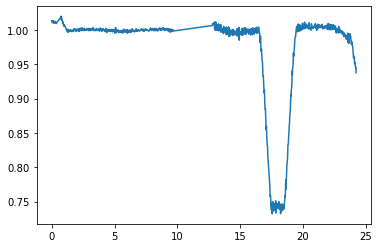

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.069676    0.975269  0.004855  0.071493     100.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.002806    0.141468  ...      -0.259718   

        mbp    mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.853838  0.00738  0.013824  0.024245  0.057201  0.461279    0.267376   

   magratio  mstat  
0  0.074734  1.543  

[1 rows x 61 columns]


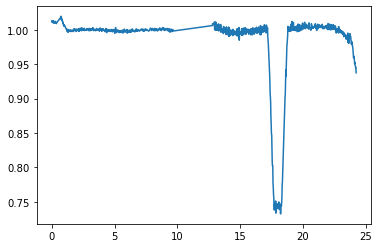

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.053887    0.985926  0.002904  0.054674      61.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0            33.0         33.0  0.00243    0.146435  ...      -0.114721   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.913775  0.009966  0.019558  0.031083  0.05507  0.138946    0.267407   

   magratio  mstat  
0  0.074412  1.276  

[1 rows x 61 columns]
[13020. 17870. 23994. 35075. 45742. 68837.]


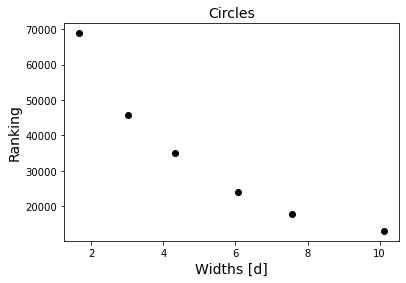

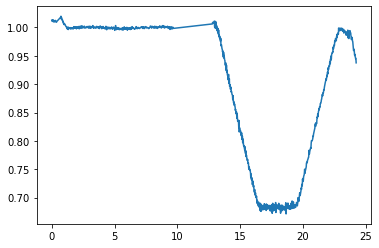

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.127221    0.910403  0.016185  0.141642     235.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.020176    0.137272  ...       -0.39504   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.561514  0.239245  0.485777  0.696222  0.930198  0.984583     0.31975   

   magratio  mstat  
0  0.098899  1.126  

[1 rows x 61 columns]


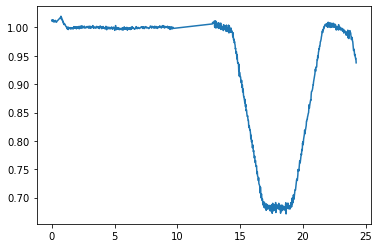

       stds  meanmedrat    varss  coeffvar  numout1s  numposoutliers  \
0  0.118615    0.925725  0.01407  0.128436     200.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.005564    0.138071  ...      -0.363423   

        mbp     mid20    mid35    mid50     mid65     mid80  percentamp  \
0  0.652997  0.023688  0.17327  0.44634  0.756635  0.970721    0.327287   

   magratio  mstat  
0  0.066075   1.29  

[1 rows x 61 columns]


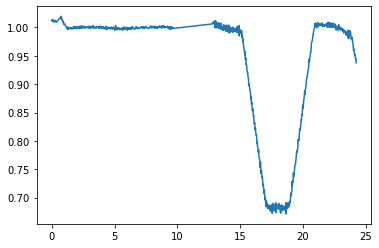

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.110395    0.940382  0.012187  0.117599     174.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.004239    0.141477  ...      -0.330836   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.720294  0.009389  0.034719  0.201978  0.59174  0.944394    0.327709   

   magratio  mstat  
0  0.064208  1.381  

[1 rows x 61 columns]


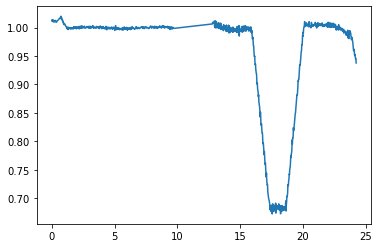

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.097381    0.957112  0.009483  0.101846     137.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.003344    0.142613  ...      -0.269362   

        mbp     mid20     mid35     mid50    mid65     mid80  percentamp  \
0  0.798107  0.006745  0.014775  0.030681  0.25834  0.754928    0.327164   

   magratio  mstat  
0  0.062093  1.507  

[1 rows x 61 columns]


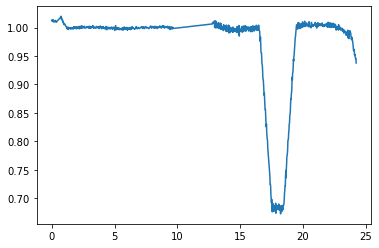

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.084108    0.969791  0.007074  0.086789     104.0             0.0   

   numnegoutliers  numoutliers       mad  meanpslope  ...  sautocorrcoef  \
0             0.0          0.0  0.002822    0.145232  ...      -0.187733   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.853838  0.006122  0.011511  0.020193  0.055731  0.476113    0.327117   

   magratio  mstat  
0  0.061503   1.55  

[1 rows x 61 columns]


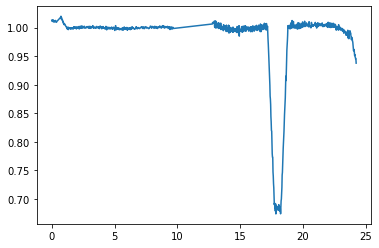

       stds  meanmedrat     varss  coeffvar  numout1s  numposoutliers  \
0  0.064942    0.982887  0.004217  0.066094      64.0             0.0   

   numnegoutliers  numoutliers      mad  meanpslope  ...  sautocorrcoef  \
0            32.0         32.0  0.00243    0.150806  ...      -0.021567   

        mbp     mid20     mid35     mid50     mid65     mid80  percentamp  \
0  0.913775  0.008395  0.016474  0.026182  0.046387  0.119086    0.326174   

   magratio  mstat  
0  0.060993  1.292  

[1 rows x 61 columns]
[13532. 15837. 22425. 35688. 45566. 81211.]


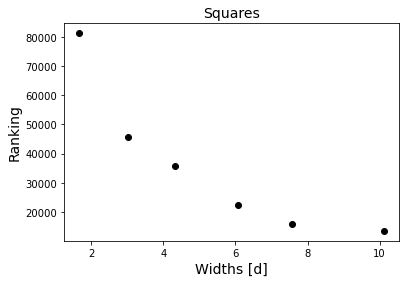

In [22]:
#widths

rank_scores = np.array([])
to_score_total = pd.DataFrame()
feats = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/db.v2.h5", "S18/features")
sector_scores = pd.read_hdf("/home/jupyter/mountpoint/dataproducts/s18rescore.h5", "S18/scores")

for shape in ( 'Triangle','Circle', 'Square'):
    fluxes = pd.read_csv("subplot_data/" + shape+ "_width_spike.csv")
    shape_scores = np.array([])
    shape_depths = np.array([])
    
    if shape == 'Triangle':
        depths = range(1,7)
    else:
        depths = range(1,7)
    for num in depths:
        plt.plot( fluxes['Time'].values,fluxes["Flux%s" %(num)].values)
        plt.show()

        test_time = fluxes["Time"].values
        test_flux = fluxes["Flux%s" %(num)].values
        test_err = np.zeros_like(test_flux, dtype='uint8')
        
        
        
        test_features = features.feats(test_time, test_flux, test_err)

        test_features = pd.DataFrame(columns=test_features.keys(), data=[test_features.values()])

        mstat = features.calc_mstat(test_flux)

        test_features['mstat'] = mstat
        test_feats =test_features
        print(test_feats)

        # Scoring 

        sample_subset = get_subset(18).iloc[:,:61]
        to_score = test_feats        
        #print(to_score)

        to_score_total = to_score_total.append(to_score)
        
        
        scores = dist_scores(sample_subset, to_score, k=1, scaler=data_scaler)
        scores_df = pd.DataFrame(data=scores.T, columns=["scores"])


        shape_score = (sector_scores[sector_scores.scores>scores[0]]['rank'].max()+1)
 
        
        shape_scores = np.append(shape_scores, shape_score)

        depth = min(fluxes["Flux%s" %(num)].values)
        shape_depths = np.append(shape_depths, depth)
        #print(shape_depths)

        
    shape_widths = fluxes["Widths"].values
    shape_widths = shape_widths[~np.isnan(shape_widths)]
    #shape_depths = 1-shape_depths
    print(shape_scores)
    plt.title(str(shape) + 's', fontsize=14)
    plt.xlabel("Widths [d]", fontsize = 14)
    plt.ylabel("Ranking", fontsize = 14)
    plt.scatter(shape_widths, shape_scores, color = 'black')
    
    plt.show()
    
    widths_rankings = pd.DataFrame({'Widths':shape_widths, 'Ranking':shape_scores})
    widths_rankings.to_csv(shape + '_widths_rankings.csv', index=True)


    
#sample_subset.to_csv('sample_subset.csv', index=True)


In [106]:
print(sector_scores[sector_scores.TIC_ID ==453152796])

     scores       rank     TIC_ID
0  0.000409  2293913.0  453152796


In [ ]:
shape_depths = 1-shape_depths
plt.title(shape)
plt.xlabel("Transit Depth")
plt.ylabel("Ranking")
plt.scatter(shape_depths, shape_scores)
plt.show()

print(to_score_total)

to_score_total.to_csv('features.csv', index=True)

print(rank_scores)
#tri_scores=rank_scores

shape_scores = rank_scores#np.array([9., 9., 9., 9. 9. 6.])
shape_depths = np.array([])

for num in range(1,13):
    depth = min(fluxes["Flux%s" %(num)].values)
    shape_depths = np.append(shape_depths, depth)
    
shape_depths = 1-shape_depths
print(shape_depths)

plt.title(shape)
plt.xlabel("Transit Depth")
plt.ylabel("Ranking")
plt.scatter(shape_depths, shape_scores)
print(len(shape_depths), len(shape_scores))


             longtermtrend  meanmedrat     skews     varss  coeffvar  stds  \
468603196.0       0.003580    1.000476  0.000013  0.003578      47.0  14.0   
428047465.0       0.062522    1.008662  0.003909  0.061985     114.0   8.0   
368686574.0       0.024312    0.998920  0.000591  0.024338      51.0   2.0   
229948967.0       0.006656    0.999734  0.000044  0.006658     118.0   0.0   
427605720.0       0.005271    1.000979  0.000028  0.005266      78.0  18.0   
...                    ...         ...       ...       ...       ...   ...   
370346985.0       0.004043    1.000093  0.000016  0.004043     163.0   0.0   
319919602.0       0.080891    1.015077  0.006543  0.079689      59.0  10.0   
72147657.0        0.007434    1.000506  0.000055  0.007431      38.0  10.0   
423745782.0       0.013660    0.997403  0.000187  0.013696      84.0   4.0   
252183838.0       0.018624    1.002895  0.000347  0.018570      45.0  11.0   

             numoutliers  numnegoutliers  numposoutliers  numou

(0.0001, 1.0)

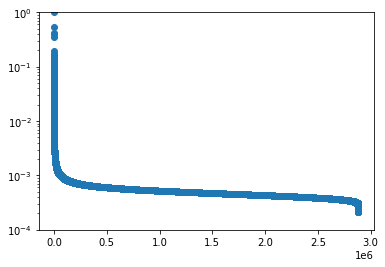

In [143]:
plt.scatter(sector_scores['rank'], sector_scores.scores)
plt.yscale('log')
plt.ylim(1E-4, 1E0)

# Appendix: Scaling distances -> scores

In [65]:
scores_df["TIC_ID"] = sample_subset.index.astype(int)

In [75]:
refpoints = sector_scores[sector_scores.TIC_ID.isin(scores_df.head(2).TIC_ID)].reset_index()

In [69]:
scores_df.head(2)

,scores,TIC_ID
0,2.317967,468603196
1,2.774197,428047465


In [76]:
refpoints

,index,scores,rank,TIC_ID
0,224696,0.000423,2131928.5,468603196
1,2711288,0.000506,1164110.5,428047465


In [89]:
diff_abs = scores_df.head(2).loc[1, 'scores']-scores_df.head(2).loc[0, 'scores']

dif_scaled = refpoints.loc[1,'scores']-refpoints.loc[0,'scores']

factor = dif_scaled/diff_abs

offset = refpoints.loc[1,'scores']-factor*scores_df.head(2).loc[1, 'scores']

In [108]:
print(f"score = {factor:.3E} * distance + {offset:.3E}")

score = 1.826E-04 * distance + -4.340E-12


0    -0.038648
1    -0.037302
2    -0.035795
3    -0.034245
4    -0.032597
5    -0.030904
6    -0.029096
7    -0.027321
8    -0.025428
9    -0.023481
10   -0.021477
11   -0.021017
Name: longtermtrend, dtype: float64


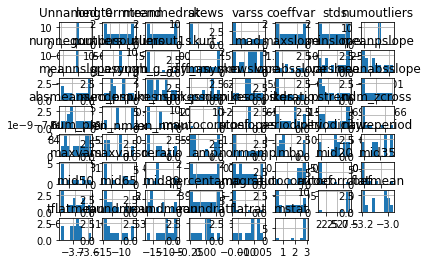

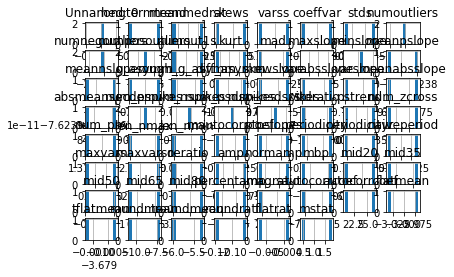

In [27]:
features = pd.read_csv("features.csv")
print(features[features.columns[1]])
outliers = (features.tail(2))


#fig = plt.figure(figsize=(25,30))
#ax = fig.gca()
features.hist()#(ax = ax)
outliers.hist()#(ax = ax)
plt.show()

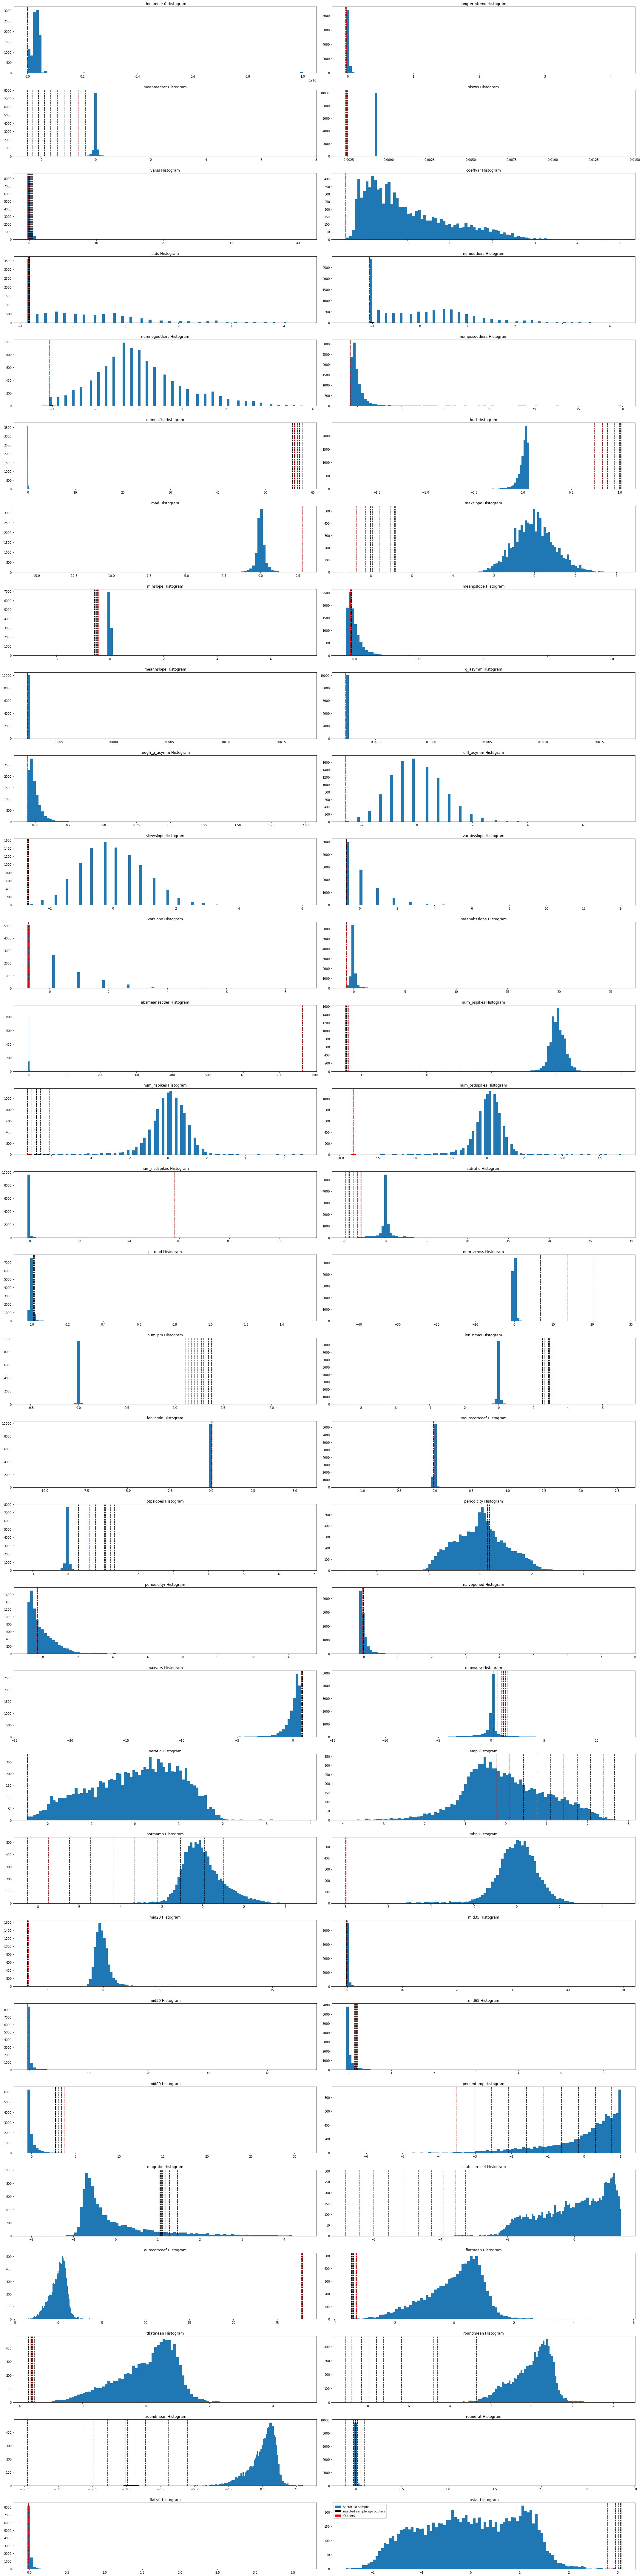

In [100]:
import pandas as pd
import matplotlib.pyplot as plt
sample_subset=pd.read_csv("sample_subset.csv")
features = pd.read_csv("features.csv")
features=features.head(10)
outliers = features.tail(2)

#num_columns = features.shape[1]

num_rows = 6
num_cols = 11

fig, axs = plt.subplots(31, 2, figsize=(30,120))

axs = axs.flatten()

for i, column in enumerate(features.columns):
    axs[i].hist(sample_subset[column], bins=100, label = 'sector 18 sample')
    axs[i].hist(features[column], label = 'injected sample w/o outliers', bins=10, color = 'black')
    axs[i].hist(outliers[column], label='Outliers', color ='red', bins=3)
    axs[i].set_title(f"{column} Histogram")
    
        
    for injected_value in features[column]:
        axs[i].axvline(injected_value, color='black', linestyle='dashed')
    for outlier_value in outliers[column]:
        axs[i].axvline(outlier_value, color='red', linestyle='dashed')


plt.tight_layout()
plt.legend()
plt.show()


In [73]:
mstat_gt_1 = sample_subset[sample_subset['mstat'] > 1]
print(len(mstat_gt_1))


2000
